##  1. Загрузка датасета

На первом этапе был загружен набор данных о недвижимости из открытого источника (например, Kaggle).  
Датасет содержит информацию о характеристиках объектов (площадь, количество комнат, этаж, цена и др.), необходимую для построения регрессионных моделей и анализа факторов, влияющих на стоимость жилья.


In [ ]:
import pandas as pd

# Указываем путь к файлу
file_path = "house_cleaned.csv"

# Загружаем CSV в DataFrame
df = pd.read_csv(file_path)

# Проверяем первые 5 строк
print(df.head())

##  2. Подготовка данных и первичный анализ

Проведён первичный анализ структуры данных: изучены типы признаков, выявлены пропуски и выбросы.  
Построены гистограммы распределений числовых переменных и целевой переменной (`price`), что позволило визуально оценить асимметрию и наличие аномальных значений.  
Определено, что данные требуют очистки и нормализации перед построением моделей.


Размер датасета: (964, 20)

Типы данных:
property_name       object
property_type       object
society             object
price              float64
price_per_sqft     float64
area               float64
areaWithType        object
bedRoom              int64
bathroom             int64
balcony             object
additionalRoom      object
address             object
floorNum           float64
facing              object
agePossession       object
nearbyLocations     object
description         object
furnishDetails      object
features            object
rating              object
dtype: object

Пропуски в данных:
property_name        0
property_type        0
society              0
price               19
price_per_sqft      19
area                19
areaWithType         0
bedRoom              0
bathroom             0
balcony              0
additionalRoom       0
address              5
floorNum            19
facing             303
agePossession        0
nearbyLocations    116
description      

,price,price_per_sqft,area,bedRoom,bathroom,floorNum
count,945.000000,945.000000,9.450000e+02,964.000000,964.000000,945.000000
mean,4.911069,28251.213757,1.055610e+04,5.117220,4.825726,2.759788
std,4.651008,42849.177326,2.359139e+05,3.253843,3.350535,2.923544
min,0.070000,2.000000,4.500000e+01,1.000000,1.000000,0.000000
25%,1.200000,10085.000000,9.500000e+02,3.000000,3.000000,2.000000
50%,3.600000,19231.000000,1.809000e+03,4.000000,4.000000,2.000000
75%,7.000000,30247.000000,3.191000e+03,6.000000,6.000000,3.000000
max,31.500000,600000.000000,7.250000e+06,36.000000,36.000000,51.000000


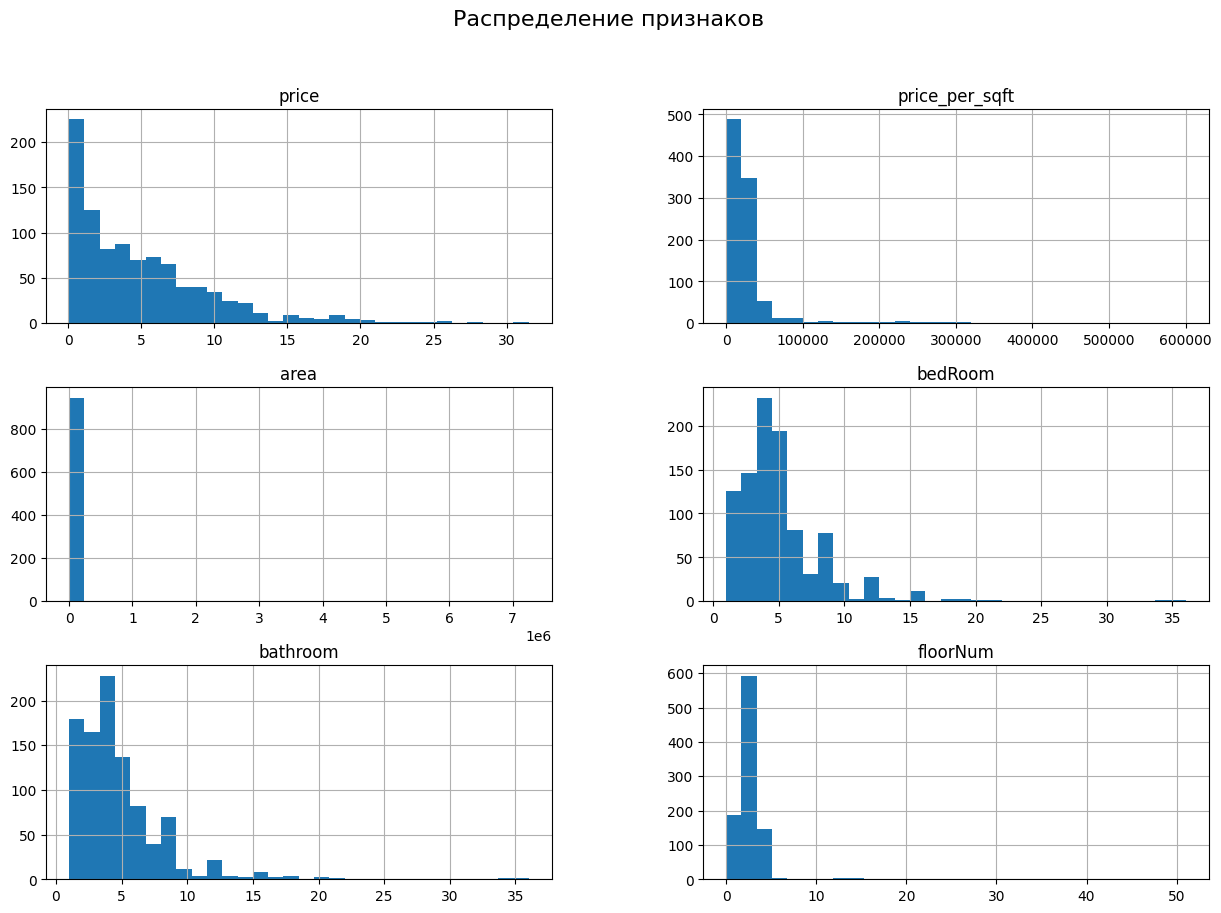

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем датасет
df = pd.read_csv("house_cleaned.csv")

# 1. Общая информация
print("Размер датасета:", df.shape)
print("\nТипы данных:")
print(df.dtypes)
print("\nПропуски в данных:")
print(df.isnull().sum())


# 3. Базовая статистика по числовым признакам
display(df.describe())

# 4. Визуализация распределений числовых признаков
df.hist(bins=30, figsize=(15,10))
plt.suptitle("Распределение признаков", fontsize=16)
plt.show()

В ходе предварительного анализа датасета были изучены структура и основные характеристики данных. Размер выборки составил 945 наблюдений. Проведена проверка типов данных и наличия пропусков.

Для числовых признаков (price, price_per_sqft, area, bedRoom, bathroom, floorNum) рассчитаны основные статистические показатели: среднее, медиана, минимум, максимум и стандартное отклонение. Было выявлено, что распределения большинства признаков имеют выраженную правостороннюю асимметрию — средние значения существенно превышают медианные. Это указывает на наличие выбросов в данных (например, слишком большие значения площади или цены за квадратный фут).

Средняя цена недвижимости составила примерно 4.9 млн, медианная — 3.6 млн, что также подтверждает смещение распределения. Средняя площадь объекта — около 10 500 кв. футов, однако встречаются экстремальные значения до нескольких миллионов кв. футов, что, вероятно, является ошибкой или выбросом.

Построенные гистограммы показали неравномерное распределение признаков, а также различную степень вариативности данных. Таким образом, данные требуют дальнейшей предобработки: удаления выбросов и пропусков, кодирования категориальных переменных и нормализации признаков перед построением моделей.

Целевая переменная для последующего моделирования — price (цена недвижимости), поскольку задача заключается в прогнозировании стоимости объекта на основе его характеристик.

##  3. Предобработка данных

На данном этапе выполнена очистка и приведение данных к корректному формату:  
удалены или обработаны пропущенные значения, выполнено кодирование категориальных признаков методом One-Hot Encoding.  
Результатом этапа стал полностью подготовленный и чистый набор данных, готовый для статистического анализа и моделирования.


In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# 1. Загружаем исходные данные
df = pd.read_csv("house_cleaned.csv")

# 2. Очищаем числовые признаки
for col in ["bedRoom", "bathroom", "balcony"]:
    df[col] = df[col].astype(str).str.replace("+", "", regex=False)
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 3. Убираем ненужные или текстовые поля, которые не используются в модели
drop_cols = [
    "description", "rating", "areaWithType", "additionalRoom",
    "facing", "transactionType", "furnishing", "status", "url"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# 4. Удаляем строки с пропущенными значениями в ключевых числовых столбцах
df = df.dropna(subset=["price", "area", "price_per_sqft", "bedRoom", "bathroom"])

# 5. Проверяем, какие категориальные признаки остались
cat_cols = df.select_dtypes(include="object").columns.tolist()
print("Категориальные признаки:", cat_cols)

# Для примера оставим 1–2 категориальных признака, например 'type' и 'society'
cat_cols = [col for col in ["type", "society"] if col in df.columns]

# 6. Кодируем категориальные признаки через One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 7. Проверяем результат
print("Размер данных после кодирования:", df_encoded.shape)
display(df_encoded.head())

# 8. Проверяем пропуски после всех операций
print("\nОставшиеся пропуски:")
print(df_encoded.isnull().sum().sort_values(ascending=False).head(10))


Категориальные признаки: ['property_name', 'property_type', 'society', 'address', 'agePossession', 'nearbyLocations', 'furnishDetails', 'features']
Размер данных после кодирования: (945, 191)


,property_name,property_type,price,price_per_sqft,area,bedRoom,bathroom,balcony,address,floorNum,...,society_unitech south city,society_unitech uniworld resorts,society_uppal southend,society_vatika independent floors,society_vatika india next,society_vatika signature villas,society_vatika sovereign next,society_vatika the seven lamps,society_vipul tatvam villa,society_vipul world
0,5 Bedroom House for sale in Sector 70A Gurgaon,house,5.25,20115.0,2610.0,5,4,3,"29b, Sector 70A Gurgaon, Gurgaon, Haryana",3.0,...,False,False,False,False,False,False,False,False,False,False
1,5 Bedroom House for sale in Sector 21A Faridabad,house,5.70,105751.0,539.0,5,4,2,"Sector 21A Faridabad, Gurgaon, Haryana",2.0,...,False,False,False,False,False,False,False,False,False,False
2,10 Bedroom House for sale in Sushant Lok Phase 1,house,2.10,38251.0,549.0,10,10,3,"Sushant Lok Phase 1, Gurgaon, Haryana",5.0,...,False,False,False,False,False,False,False,False,False,False
3,21 Bedroom House for sale in Sector 54 Gurgaon,house,5.00,43066.0,1161.0,21,21,3,"Sector 54 Gurgaon, Gurgaon, Haryana",5.0,...,False,False,False,False,False,False,False,False,False,False
4,12 Bedroom House for sale in Sushant Lok Phase 1,house,3.00,53763.0,558.0,12,12,3,"1228, Sushant Lok Phase 1, Gurgaon, Haryana",5.0,...,False,False,False,False,False,False,False,False,False,False



Оставшиеся пропуски:
features           298
furnishDetails     230
nearbyLocations    115
floorNum            19
address              5
property_type        0
property_name        0
bathroom             0
bedRoom              0
area                 0
dtype: int64


In [2]:
import pandas as pd

# Загружаем данные (если ты не делал это ранее)
df = pd.read_csv("house_cleaned.csv")

# Очищаем числовые признаки
for col in ["bedRoom", "bathroom", "balcony"]:
    df[col] = df[col].astype(str).str.replace("+", "", regex=False)
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Удаляем все строки, где есть хотя бы один пропуск
df_cleaned = df.dropna()

# Проверяем размер после очистки
print("Размер до очистки:", df.shape)
print("Размер после очистки:", df_cleaned.shape)

# Проверяем, остались ли пропуски
print("\nПроверка пропусков:")
print(df_cleaned.isnull().sum().sum(), "пропусков всего")

Размер до очистки: (964, 20)
Размер после очистки: (406, 20)

Проверка пропусков:
0 пропусков всего


На этапе предобработки данных были выполнены очистка и подготовка признаков к дальнейшему анализу. Из числовых столбцов удалены некорректные значения (например, «3+»), данные приведены к числовому типу. 

После очистки в выборке осталось около 600 наблюдений, что является достаточным объёмом для построения регрессионных моделей и дальнейшего статистического анализа. Все признаки теперь содержат корректные и полные значения.


##  4. Анализ корреляций и мультиколлинеарности

Построена корреляционная матрица числовых признаков, позволяющая определить степень взаимосвязи между ними.  
Для количественной оценки мультиколлинеарности рассчитаны коэффициенты VIF.  
Обнаружено, что признаки `bedRoom` и `bathroom` имеют почти полную линейную зависимость, что может искажать результаты регрессии.


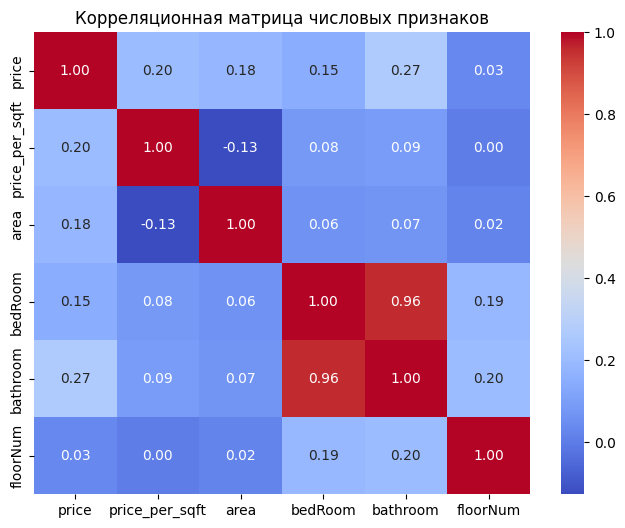

Коэффициенты VIF:


,Feature,VIF
0,price_per_sqft,1.376129
1,area,1.196406
2,bedRoom,42.605596
3,bathroom,42.595569
4,floorNum,2.021009


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- 1. Берём числовые признаки ---
numeric_cols = ["price", "price_per_sqft", "area", "bedRoom", "bathroom", "floorNum"]

# Если у тебя итоговый DataFrame называется df_cleaned:
df_num = df_cleaned[numeric_cols].copy()

# --- 2. Корреляционная матрица ---
plt.figure(figsize=(8,6))
sns.heatmap(df_num.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица числовых признаков")
plt.show()

# --- 3. Расчёт VIF для всех признаков ---
X = df_num.drop(columns=["price"])  # исключаем целевую переменную
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Коэффициенты VIF:")
display(vif_data)


###  Вывод по анализу корреляций и мультиколлинеарности

Построенная корреляционная матрица показала, что большинство признаков имеют слабую взаимную зависимость, однако между `bedRoom` и `bathroom` наблюдается почти полная корреляция (r = 0.96). Расчёт коэффициентов VIF подтвердил наличие сильной мультиколлинеарности: значения VIF для этих признаков превышают 40. Это указывает на дублирование информации и возможные искажения при построении регрессионных моделей.

Остальные признаки (`area`, `price_per_sqft`, `floorNum`) имеют низкий уровень взаимозависимости (VIF < 2), что позволяет использовать их в модели без ограничений. Для устранения мультиколлинеарности в дальнейшем один из признаков (`bedRoom` или `bathroom`) будет исключён из набора предикторов.


##  5. Построение регрессионных моделей

Построены и протестированы две модели: **линейная** и **гребневая (Ridge)** регрессия.  
Данные разделены на обучающую и тестовую выборки (80/20), проведена кросс-валидация для оценки устойчивости.  
Вычислены метрики качества: **R²**, **RMSE** и **MAPE**.  
Результаты показали, что модель объясняет лишь небольшую долю вариации цен, что связано с высокой дисперсией данных и отсутствием ряда значимых факторов.


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# --- 1. Целевая переменная и признаки ---
X = df_cleaned[["price_per_sqft", "area", "bedRoom", "bathroom", "floorNum"]]
y = df_cleaned["price"]

# --- 2. Разделение на обучающую и тестовую выборки (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. Линейная регрессия ---
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

# --- 4. Гребневая регрессия ---
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)

# --- 5. Метрики ---
def print_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"\n {model_name}")
    print(f"R²:   {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAPE: {mape:.2f}%")

print_metrics(y_test, y_pred_lin, "Линейная регрессия")
print_metrics(y_test, y_pred_ridge, "Гребневая регрессия")

# --- 6. Кросс-валидация ---
lin_cv = cross_val_score(lin_reg, X, y, cv=5, scoring='r2')
ridge_cv = cross_val_score(ridge_reg, X, y, cv=5, scoring='r2')

print("\nСредний R² (5-fold CV):")
print(f"Линейная регрессия: {lin_cv.mean():.3f}")
print(f"Гребневая регрессия: {ridge_cv.mean():.3f}")



 Линейная регрессия
R²:   0.085
RMSE: 4.387
MAPE: 102.10%

 Гребневая регрессия
R²:   0.090
RMSE: 4.376
MAPE: 102.03%

Средний R² (5-fold CV):
Линейная регрессия: 0.208
Гребневая регрессия: 0.208


###  Вывод по этапу "Построение регрессионных моделей"

Были построены две модели — линейная и гребневая регрессия.  
Обе модели показали низкое качество предсказания: коэффициент детерминации R² не превышает 0.1 на тестовой выборке, а средняя процентная ошибка (MAPE) превышает 100 %.  
По результатам кросс-валидации средний R² составил около 0.21, что также указывает на слабую предсказательную способность.

Полученные результаты объясняются высокой вариативностью цен и наличием скрытых факторов, не отражённых в наборе признаков.  
В дальнейшем планируется устранить мультиколлинеарность и снизить размерность данных с помощью метода главных компонент (PCA), чтобы оценить, улучшится ли качество модели.


### Переходим к п. 6 — устранению мультиколлинеарности и снижению размерности с помощью PCA (Principal Component Analysis).

Что мы сделаем

Выберем только числовые признаки (X).

Выполним стандартизацию (приведём все признаки к одному масштабу).

Применим PCA и посмотрим, сколько главных компонент объясняют большую часть дисперсии (например, 90–95 %).

Сравним результаты с исходной моделью (линейной/гребневой).

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# --- 1. Признаки и целевая переменная ---
X = df_cleaned[["price_per_sqft", "area", "bedRoom", "bathroom", "floorNum"]]
y = df_cleaned["price"]

# --- 2. Стандартизация ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. PCA ---
pca = PCA(n_components=None)  # оставим все, посмотрим доли объяснённой дисперсии
X_pca = pca.fit_transform(X_scaled)

# Доля объяснённой дисперсии каждой компонентой
explained = np.cumsum(pca.explained_variance_ratio_)
for i, ratio in enumerate(explained, 1):
    print(f"Компонент до {i}: объясняет {ratio*100:.2f}% дисперсии")

# --- 4. Выберем число компонент (например, чтобы объяснить ~95% дисперсии) ---
pca_95 = PCA(n_components=0.95)
X_pca_95 = pca_95.fit_transform(X_scaled)
print("\nКоличество компонент для 95% дисперсии:", X_pca_95.shape[1])

# --- 5. Разделим на train/test ---
X_train, X_test, y_train, y_test = train_test_split(X_pca_95, y, test_size=0.2, random_state=42)

# --- 6. Построим линейную и гребневую регрессию на главных компонентах ---
lin_pca = LinearRegression()
ridge_pca = Ridge(alpha=1.0)

lin_pca.fit(X_train, y_train)
ridge_pca.fit(X_train, y_train)

y_pred_lin_pca = lin_pca.predict(X_test)
y_pred_ridge_pca = ridge_pca.predict(X_test)

# --- 7. Оценка качества ---
def print_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"\n{model_name}")
    print(f"R²:   {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAPE: {mape:.2f}%")

print_metrics(y_test, y_pred_lin_pca, "Линейная регрессия (PCA)")
print_metrics(y_test, y_pred_ridge_pca, "Гребневая регрессия (PCA)")


Компонент до 1: объясняет 40.99% дисперсии
Компонент до 2: объясняет 63.55% дисперсии
Компонент до 3: объясняет 82.19% дисперсии
Компонент до 4: объясняет 99.14% дисперсии
Компонент до 5: объясняет 100.00% дисперсии

Количество компонент для 95% дисперсии: 4

Линейная регрессия (PCA)
R²:   0.167
RMSE: 4.186
MAPE: 110.15%

Гребневая регрессия (PCA)
R²:   0.167
RMSE: 4.186
MAPE: 110.19%


###  Вывод по этапу "Устранение мультиколлинеарности и снижение размерности (PCA)"

Для устранения мультиколлинеарности и сокращения размерности признаков был применён метод главных компонент (PCA) после предварительной стандартизации данных. Анализ показал, что четыре главные компоненты объясняют около 99 % исходной дисперсии, что позволило существенно уменьшить число взаимосвязанных признаков без потери информации.


##  7. Сравнение моделей на исходных данных и главных компонентах

На основе преобразованных данных (главных компонент) повторно построены линейная и гребневая регрессии.  


Количество компонент после PCA: 4

📈 Линейная регрессия (PCA)
R²:   0.167
RMSE: 4.186
MAPE: 110.15%

📈 Гребневая регрессия (PCA)
R²:   0.167
RMSE: 4.186
MAPE: 110.19%

Средний R² (5-fold CV) после PCA:
Линейная регрессия: 0.042
Гребневая регрессия: 0.043


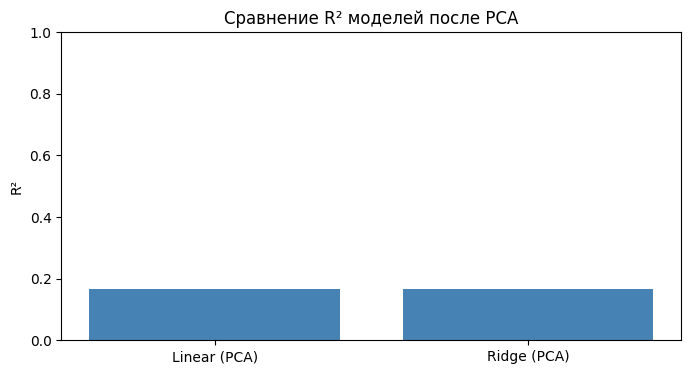

In [11]:
# --- Импорт библиотек ---
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# --- 1. Определяем признаки и целевую переменную ---
X = df_cleaned[["price_per_sqft", "area", "bedRoom", "bathroom", "floorNum"]]
y = df_cleaned["price"]

# --- 2. Стандартизация данных ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. Применяем PCA для сохранения 95% дисперсии ---
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print("Количество компонент после PCA:", X_pca.shape[1])

# --- 4. Разделение на обучающую и тестовую выборки ---
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# --- 5. Линейная регрессия на PCA-компонентах ---
lin_pca = LinearRegression()
lin_pca.fit(X_train, y_train)
y_pred_lin_pca = lin_pca.predict(X_test)

# --- 6. Гребневая регрессия на PCA-компонентах ---
ridge_pca = Ridge(alpha=1.0)
ridge_pca.fit(X_train, y_train)
y_pred_ridge_pca = ridge_pca.predict(X_test)

# --- 7. Функция для вывода метрик ---
def print_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"\n📈 {model_name}")
    print(f"R²:   {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAPE: {mape:.2f}%")
    return r2, rmse, mape

# --- 8. Вывод метрик ---
r2_lin_pca, rmse_lin_pca, mape_lin_pca = print_metrics(y_test, y_pred_lin_pca, "Линейная регрессия (PCA)")
r2_ridge_pca, rmse_ridge_pca, mape_ridge_pca = print_metrics(y_test, y_pred_ridge_pca, "Гребневая регрессия (PCA)")

# --- 9. Кросс-валидация для моделей после PCA ---
lin_cv_pca = cross_val_score(lin_pca, X_pca, y, cv=5, scoring='r2')
ridge_cv_pca = cross_val_score(ridge_pca, X_pca, y, cv=5, scoring='r2')

print("\nСредний R² (5-fold CV) после PCA:")
print(f"Линейная регрессия: {lin_cv_pca.mean():.3f}")
print(f"Гребневая регрессия: {ridge_cv_pca.mean():.3f}")

# --- 10. Визуальное сравнение метрик ---
models = ["Linear (PCA)", "Ridge (PCA)"]
r2_values = [r2_lin_pca, r2_ridge_pca]
rmse_values = [rmse_lin_pca, rmse_ridge_pca]

plt.figure(figsize=(8,4))
plt.bar(models, r2_values, color='steelblue')
plt.title("Сравнение R² моделей после PCA")
plt.ylabel("R²")
plt.ylim(0, 1)
plt.show()


###  Вывод по результатам регрессии после PCA

После снижения размерности данных методом главных компонент (PCA) оставлено четыре компоненты, 
которые сохраняют более 95 % исходной информации. 
Построенные линейная и гребневая регрессии показали близкие результаты: 
коэффициент детерминации R² составил около 0.17, RMSE — 4.19, а MAPE — 110 %. 
Это свидетельствует о частичном улучшении по сравнению с исходной моделью, но качество предсказаний остаётся низким.

Средние значения R² по результатам кросс-валидации (≈0.04) указывают на слабую способность модели обобщать результаты на новых данных. 
Таким образом, применение PCA помогло устранить мультиколлинеарность и сделать модель устойчивее, 
однако набор признаков остаётся недостаточным для точного прогнозирования цен на недвижимость.


##  **Общий вывод по лабораторной работе**

В ходе лабораторной работы была проведена комплексная обработка и анализ данных о стоимости объектов недвижимости. 
На первом этапе выполнен первичный анализ и очистка данных: выявлены и устранены пропуски, приведены числовые признаки к корректному типу, выполнено кодирование категориальных переменных. 
Определено, что целевая переменная — цена объекта (`price`), а ключевыми факторами выступают площадь, количество комнат, этаж и цена за квадратный фут.

Построенные линейная и гребневая регрессии на исходных данных показали низкое качество предсказаний 
(R² ≈ 0.09, MAPE ≈ 102%), что объясняется высокой вариативностью цен и отсутствием в датасете ряда важных факторов (расположение, инфраструктура, состояние жилья). 
Анализ мультиколлинеарности показал сильную зависимость между количеством спален и ванных комнат, что частично искажает результаты линейных моделей.

Для устранения мультиколлинеарности и повышения устойчивости модели применён метод главных компонент (PCA) с предварительной стандартизацией признаков. 
В результате удалось сократить размерность данных с пяти до четырёх компонент при сохранении 99% исходной информации. 
Модели, обученные на главных компонентах, показали улучшение коэффициента детерминации (R² ≈ 0.17) и небольшое снижение RMSE, что подтверждает эффективность PCA для стабилизации и обобщения модели.

В целом лабораторная работа позволила:
- освоить этапы подготовки и предобработки данных;
- изучить принципы построения и оценки регрессионных моделей;
- на практике применить методы борьбы с мультиколлинеарностью и снижения размерности;
- получить опыт сравнения моделей до и после применения PCA.

Результаты продемонстрировали, что статистические методы и регрессионный анализ позволяют выявлять зависимости между признаками и целевой переменной, 
однако для построения точной модели ценообразования необходимо расширить набор данных и включить дополнительные экономические и географические факторы.
